# Spam and Non-Spam Mail Classifiction

##  Importing necessary libraries and modules 

In [1]:
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import gensim.downloader as api
from gensim.models import KeyedVectors
import numpy as np
from sklearn.svm import SVC
import gensim
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Kholoud\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kholoud\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kholoud\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kholoud\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Reading Data

In [4]:
data = pd.read_csv("Spam_Email_Data (1).csv")
sum = data.duplicated().sum()
data.drop_duplicates(inplace = True) 

                                                text  target
0  From ilug-admin@linux.ie Mon Jul 29 11:28:02 2...       0
1  From gort44@excite.com Mon Jun 24 17:54:21 200...       1
2  From fork-admin@xent.com Mon Jul 29 11:39:57 2...       1
3  From dcm123@btamail.net.cn Mon Jun 24 17:49:23...       1
4  From ilug-admin@linux.ie Mon Aug 19 11:02:47 2...       0
5  From tobaccodemon@terra.es Sat Sep 7 22:05:58 ...       1
6  From larlar78@MailOps.Com Sat Jun 30 00:19:08 ...       1
7  From rpm-list-admin@freshrpms.net Thu Jul 25 1...       0
8  From exmh-users-admin@redhat.com Wed Aug 7 06:...       0
9  From contractor@goldenbay.com.cy Tue Jul 23 23...       1


## Data Pre-processing

In [69]:
# convert the email to lowercase 
def to_lowercase(mail):
    return mail.lower()

In [70]:
# removal of whitespaces like tabs from mail
def remove_whitespaces(mail):
    mail = mail.strip()
    return mail

In [71]:
# remove punctuation from the mail 
def remove_punctuation(mail):
    mail = re.sub(r'[^\w\s]', ' ', mail) 
    return mail

In [72]:
# remove links from the mail like http://www.welcome.com
def remove_links(mail):
    url_link_pattern = "https?://(?:www\.)?\S+"
    mail = re.sub(url_link_pattern,'',mail)
    return mail

In [73]:
#function to remove dates from the mail

def remove_dates_from_mail(mail):
    date_pattern = r'\b(?:mon|tue|wed|thu|fri|sat|sun)\s(?:jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\s\d{1,2}\s\d{2}:\d{2}:\d{2}\s\d{4}\b'
    mail = re.sub(date_pattern, '', mail)
    return mail

In [74]:
# function to remove mail addresses from mail 
def remove_mail_address_from_mail(mail):
    email_address_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    mail = re.sub(email_address_pattern,'',mail)
    return mail

In [75]:
# get pos tag of word (Verb, Noun, Adj, Adv)
def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

In [76]:
def tokenize_mail(mail):
    return word_tokenize(mail)

In [77]:
# function to remove stop words from mail
def remove_stop_words(tokens):
    stop_words = set(stopwords.words('english'))
    return " ".join([message for message in tokens if message not in stop_words])

In [78]:
# function to lemmatize mail
def lemmatize_mail(tokens):
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
    clean_mail = ' '.join(tokens)
    return clean_mail

In [79]:
# function to remove non alphabetic words in the mail 
def remove_non_alpha(tokens):
    mail = [word for word in tokens if word.isalpha()]
    clean_mail = " ".join(mail)
    return clean_mail

## Data Pre-Processing Order
* Convert the mail to lowercase to remove case sensitivity and prevent diversions between identical words caused by it, which helps reducing the feature space dimensionality and reducing vocabulary size which simplifies the task of machine learning as it reduces the complexity of input data.

* Removing unnecessary whitespaces for the mail

* Remove any links from the mail content
* Remove dates from the mail content
* Remove punctuation
* These 3 steps are done to remove redundunt information that doesn't give any meaningful information that helps in predicting weather the mail is s spam or not.

* Tokenizing mail text into list of tokens so that we can feed these token to the next pre-processing steps to process them
* Remove stop words from the mail because they are identified not to have much effect in classification procedures but will only increase dimensionlity of feature space and increase complexity of model's computations.
* Remove non alphabetical tokens because they won't be having any useful meaning and will only create useless diversions, so it's better to discard them
* Lemmatizing the tokens into their base form to standardize the text data, reduce the number of unique terms and improve the model's ability to generalize across different word forms. It also plays a role in reducing vocabulary size which in turn reduces computational complexity of classification model

In [80]:
def preprocess_mail(mail):
    mail = to_lowercase(mail)
    mail = remove_whitespaces(mail)
    mail = remove_links(mail)
    mail = remove_dates_from_mail(mail)
    mail = remove_mail_address_from_mail(mail)
    mail = remove_punctuation(mail)
    mail_token = tokenize_mail(mail)
    mail = remove_stop_words(mail_token)
    mail_token = tokenize_mail(mail)
    mail = remove_non_alpha(mail_token)
    mail_token = tokenize_mail(mail)
    mail = lemmatize_mail(mail_token)
    return mail

In [81]:
data['cleaned text'] = data['text'].apply(preprocess_mail)

* Splitting data into training and testing sets to create data balance between the data that will be used for training and testing.
* Splitting the data with the ratio of 60% for training is to give the model enough data to learn from and be albe to capture complex patterns in the data
* and 40% for testing is that as the data size is large then 40% will be enough amount of data to test the model on and evaluate its performance.

In [82]:
X = data['cleaned text']
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4 , random_state=42)

## Applying Word Embedding Using Different Techniques 

### 1- TF - IDF Word Embedding

#### TF-IDF
* is a common technique used to represent textual content as numerical vectors. it's used to masure how important is a word to a document in a collection of documents (Corpus). the value of TF-IDF increases as the number of times the word shows in a document increases, yet it's balanced by the number of documents in the corpus where the word appears, thereby accounting for the commonality of certain words across the corpus. This composite measure consists of two elements: TF and IDF.
##### generally it calculates how relevant is a word to a mail in a collection of mails, taking into account that some words appears more frequently than other ones.

In [84]:
# apply word embedding using tf-idf vectorizer
def apply_td_idf_embedding(xtrain,xtest,ytrain,ytest):

    tfIdf = TfidfVectorizer(ngram_range = (1, 1))
    X_train_tfidf = tfIdf.fit_transform(xtrain)
    X_test_tfidf = tfIdf.transform(xtest)
    model1=LogisticRegression()
    model1.fit(X_train_tfidf,ytrain)
    predict1=model1.predict(X_test_tfidf)
    acc1=accuracy_score(ytest,predict1)
    f1Score1=f1_score(ytest,predict1)
    cm = confusion_matrix(ytest, predict1)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix For Logistic Regression Model vs TF-IDF embedding')
    plt.show()
    
    model2=SVC(kernel='linear',C=1)
    model2.fit(X_train_tfidf,ytrain)
    predict2=model2.predict(X_test_tfidf)
    acc2=accuracy_score(ytest,predict2)
    f1Score2=f1_score(ytest,predict2)
    cm = confusion_matrix(ytest, predict2)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix For SVM Model vs TF-IDF embedding')
    plt.show()
    return acc1,f1Score1,acc2,f1Score2

#### Bag Of Words (CountVectorizer)
* is a technique used in email classification to convert text into numerical features by counting the frequency of words. It disregards word order and context, focusing solely on word occurrence. This approach simplifies text data for machine learning algorithms, enabling effective classification based on word presence.

In [85]:
# apply word embedding using Count vectorizer
def apply_bag_of_words_embedding(xtrain,xtest,ytrain,ytest):  
     
     countVectorizer = CountVectorizer()
     X_train_bag_of_words = countVectorizer.fit_transform(xtrain)
     x_test_bag_of_word=countVectorizer.transform(xtest)   
     model1=LogisticRegression()
     model1.fit(X_train_bag_of_words,ytrain)
     predict1=model1.predict(x_test_bag_of_word)
     acc1=accuracy_score(ytest,predict1)
     f1Score1=f1_score(ytest,predict1)
     cm = confusion_matrix(ytest, predict1)
    
     plt.figure(figsize=(8, 6))
     sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
     plt.xlabel('Predicted Labels')
     plt.ylabel('True Labels')
     plt.title('Confusion Matrix For Logistic Regression Model vs Bag Of Words embedding')
     plt.show()
     model2=SVC(kernel='linear',C=1)
     model2.fit(X_train_bag_of_words,ytrain)
     predict2=model2.predict(x_test_bag_of_word)
     acc2=accuracy_score(ytest,predict2)
     f1Score2=f1_score(ytest,predict2)
     cm = confusion_matrix(ytest, predict2)
    
     plt.figure(figsize=(8, 6))
     sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
     plt.xlabel('Predicted Labels')
     plt.ylabel('True Labels')
     plt.title('Confusion Matrix For SVM Model vs Bag Of Words embedding')
     plt.show()
     return acc1,f1Score1,acc2,f1Score2

#### Word2Vec
* is a word embedding technique used in mail classification to represent words as dense vectors in a continuous vector space. It captures semantic relationships between words based on their context in large text corpora. By encoding semantic meaning, Word2Vec enhances the model's understanding of textual content, leading to more accurate classification by considering word similarity and context.

In [86]:
#apply word embedding using doc2Vec 
def apply_doc2vec(data):
    data['cleaned text'] =data['text'].apply(lambda x: gensim.utils.simple_preprocess(x))
    sentences = [gensim.models.doc2vec.TaggedDocument(doc, [i]) for i, doc in enumerate(data['cleaned text'])]
    model = gensim.models.Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=10)
    model.build_vocab(sentences)
    model.train(sentences, total_examples=len(data), epochs=model.epochs)
    doc_vectors = [model.dv[idx] for idx in range(len(data))]
    X_train, X_test, y_train, y_test = train_test_split(doc_vectors, data['target'], test_size=0.4)

    model1=LogisticRegression()
    model1.fit(X_train, y_train)
    predict1=model1.predict(X_test)
    acc1=accuracy_score(y_test,predict1)
    f1Score1=f1_score(y_test,predict1)
    cm = confusion_matrix(y_test, predict1)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix For Logistic Model vs doc2vec embedding')
    plt.show()
    model2=SVC(kernel='linear',C=1)
    model2.fit(X_train, y_train)
    predict2=model2.predict(X_test)
    acc2=accuracy_score(y_test,predict2)
    f1Score2=f1_score(y_test,predict2)
    cm = confusion_matrix(y_test, predict2)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix For SVM Model vs doc2vec embedding')
    plt.show()
    return acc1,f1Score1,acc2,f1Score2



In [87]:
# Function to convert text to Word2Vec embeddings
def text_to_word2vec(text, word2vec_model):
    embedded_text = []
    for sentence in text:
        words = sentence
        vectors = [word2vec_model[word] for word in words if word in word2vec_model]
        avg_vector = np.mean(vectors, axis=0) if vectors else np.zeros(300)  
        embedded_text.append(avg_vector)
    return np.array(embedded_text)

In [88]:
def apply_word2vec_model(data):
    X = data['cleaned text']
    y = data['target']
    word2vec_path = "C:/Users/Kholoud/Desktop/GoogleNews-vectors-negative300.bin"
    word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    X_train_word2vec = text_to_word2vec(X_train, word2vec_model)
    X_test_word2vec = text_to_word2vec(X_test, word2vec_model)

    model1=LogisticRegression()
    model1.fit(X_train_word2vec, y_train)
    predict1=model1.predict(X_test_word2vec)
    acc1=accuracy_score(y_test,predict1)
    f1Score1=f1_score(y_test,predict1)
# Assuming y_true and y_pred are the true labels and predicted labels, respectively
# y_true and y_pred should be arrays or lists containing the actual and predicted labels, respectively

    cm = confusion_matrix(y_test, predict1)
    
    # Visualize confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix For Logistic Regression Model vs word2vec embedding')
    plt.show()
    model2=SVC(kernel='linear',C=1)
    model2.fit(X_train_word2vec, y_train)
    predict2=model2.predict(X_test_word2vec)
    acc2=accuracy_score(y_test,predict2)
    cm = confusion_matrix(y_test, predict2)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix For SVM Model vs word2vec embedding')
    plt.show()
    f1Score2=f1_score(y_test,predict2)

    return acc1,f1Score1,acc2,f1Score2

## Classification Models

### Logistic Regression and SVM Classification models are used to classify mails into spam and non-spam

## Models Evaluation
* ### Accuracy Score:
* It measures the proportion of correctly classified instances (both spam and non-spam) out of the total number of instances. It provides a general assessment of the model's correctness across all classes.
* ### F1 Score:
* It balances the trade-off between precision and recall and provides a single metric that considers both false positives and false negatives. F1 score is particularly useful when there is an imbalance between the number of spam and non-spam emails in the dataset.
* ### Confusion Matrix:
* It provides a detailed breakdown of the model's predictions, including true positives, true negatives, false positives, and false negatives. This allows us to get a comprehensive evaluation of the model's performance across different classes or categories.

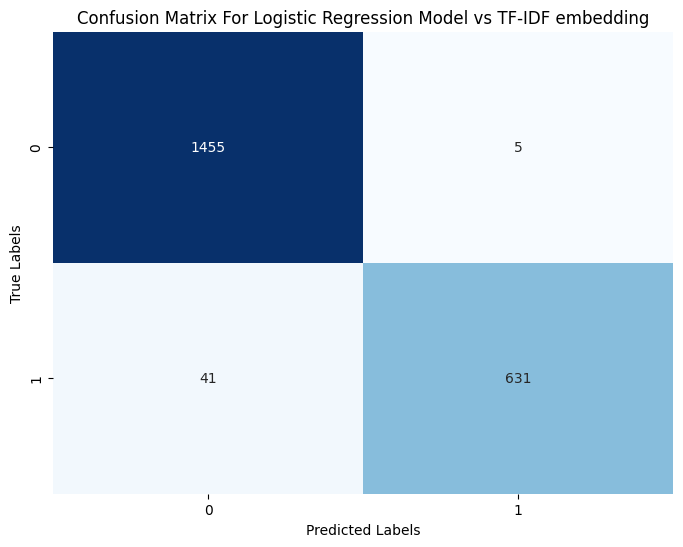

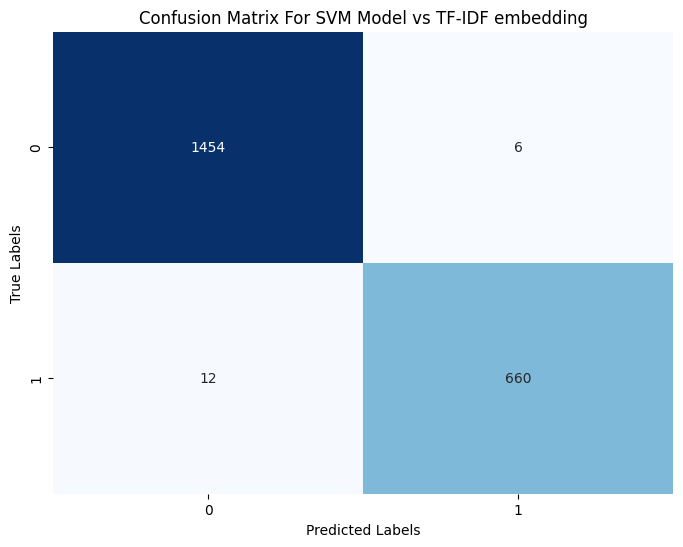

C:\Users\Kholoud\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


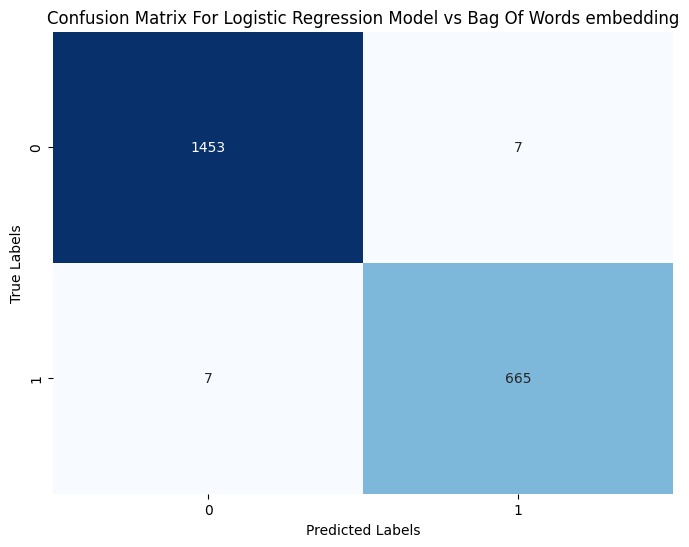

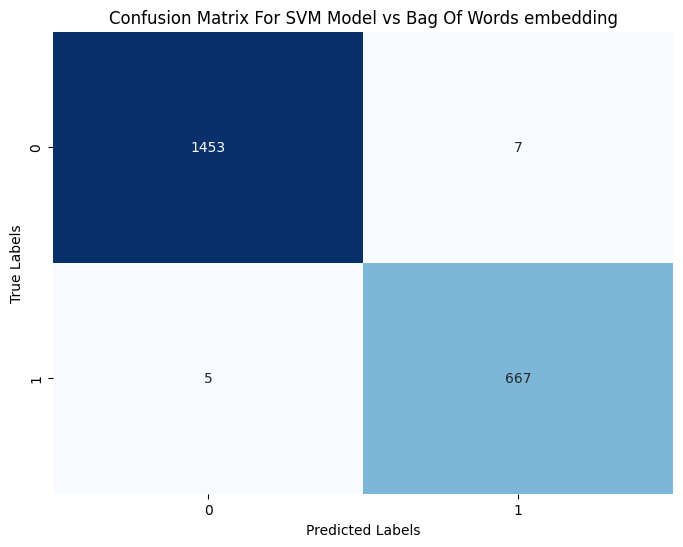

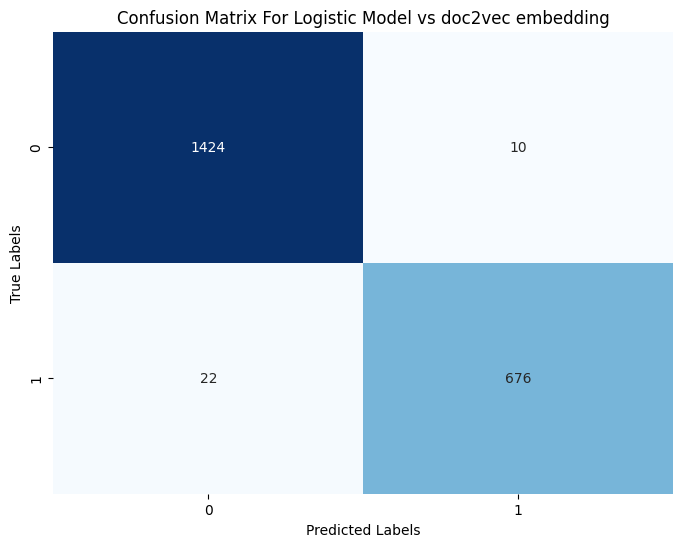

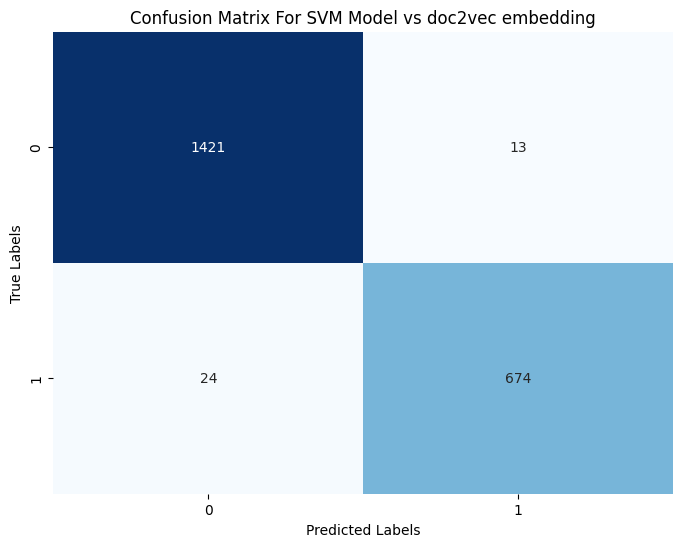

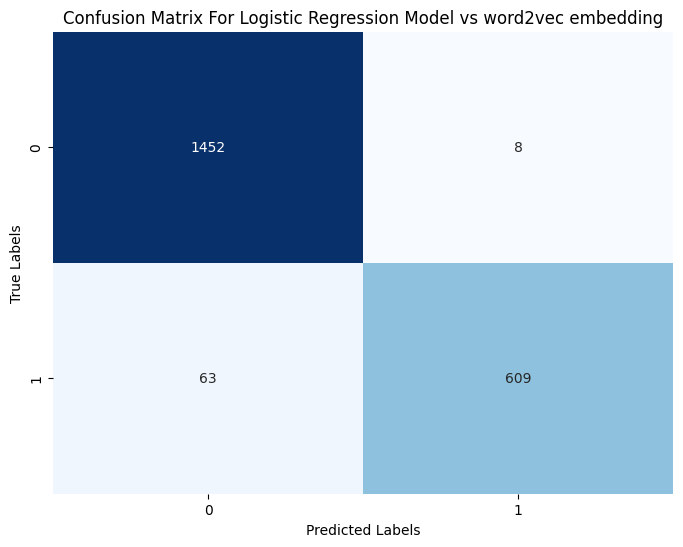

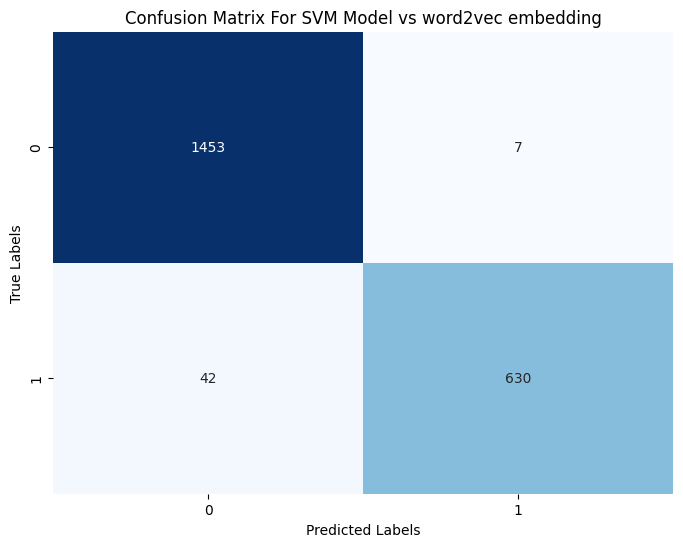

In [89]:
a,b,c,d = apply_td_idf_embedding(X_train,X_test,y_train,y_test)
e,f,g,h=apply_bag_of_words_embedding(X_train,X_test,y_train,y_test)
i,j,k,l=apply_doc2vec(data)
m,n,o,p=apply_word2vec_model(data)

In [90]:

evaluation = {
    'Accuracy using logistic regression': [a, e, i, m],
    'F1_Score using logistic regression': [b,f,j,n],
    'Accuracy using SVM': [c,g,k,o],
    'F1_Score using SVM': [d,h,l,p]
}
df = pd.DataFrame(evaluation)
df.index = ['TF-IDF', 'Count-Vectorizer', 'DOC2-VEC', 'Word2-VEC']
df

,Accuracy using logistic regression,F1_Score using logistic regression,Accuracy using SVM,F1_Score using SVM
TF-IDF,0.978424,0.964832,0.991557,0.986547
Count-Vectorizer,0.993433,0.989583,0.994371,0.991085
DOC2-VEC,0.984991,0.976879,0.982645,0.973285
Word2-VEC,0.966698,0.944919,0.977017,0.962567
